# Geospatial research


In [ ]:
%pip install geopandas
%pip install geopy
%pip install matplotlib

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

# Sample events dataframe (flatten your JSON into pandas DataFrame)
data = {
    'id': [1, 2],
    'title': ["Padua Food & Drink Event #1", "San Donà di Piave Arts & Crafts Event #2"],
    'latitude': [45.4077172, 45.6294811],
    'longitude': [11.8734455, 12.5641057],
    # add other fields as needed
}

df = pd.DataFrame(data)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

# Suppose you have a route as a LineString between Vicenza and Padua
route_coords = [(11.546699, 45.545932), (11.8734455, 45.4077172)]  # (lon, lat) tuples
route_line = LineString(route_coords)
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326")

# Reproject to metric CRS for buffering (meters)
gdf_m = gdf.to_crs(epsg=3857)
route_m = route_gdf.to_crs(epsg=3857)

# Create 1 km buffer around route
buffer = route_m.buffer(1000).iloc[0]

# Filter events within buffer polygon
events_in_buffer = gdf_m[gdf_m.geometry.within(buffer)]

# Convert filtered events back to lat/lon CRS for display
events_in_buffer_wgs = events_in_buffer.to_crs(epsg=4326)

print(events_in_buffer_wgs[['id', 'title', 'geometry']])


   id                        title                   geometry
0   1  Padua Food & Drink Event #1  POINT (11.87345 45.40772)


/tmp/ipykernel_29177/1274075854.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


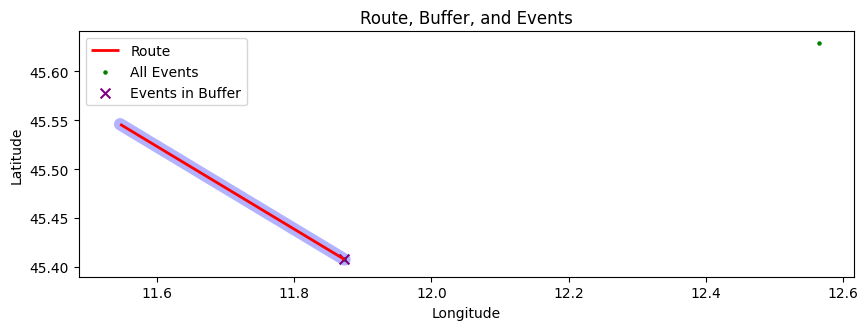

In [3]:
import matplotlib.pyplot as plt

# Plot the route and the buffer
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (converted back to WGS84 for plotting with events)
route_gdf.to_crs(epsg=4326).plot(ax=ax, color='red', linewidth=2, label='Route')

# Plot the buffer (converted back to WGS84 for plotting with events)
buffer_wgs = gpd.GeoSeries([buffer], crs=3857).to_crs(epsg=4326)
buffer_wgs.plot(ax=ax, color='blue', alpha=0.3, label='1km Buffer')

# Plot the events
gdf.to_crs(epsg=4326).plot(ax=ax, color='green', marker='o', markersize=5, label='All Events')

# Plot events within the buffer
events_in_buffer_wgs.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events in Buffer')


ax.set_title("Route, Buffer, and Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

### Query to qdrant of a route

In [2]:
import numpy as np
from shapely.geometry import LineString
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance

load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = os.getenv("COLLECTION_NAME")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)

# 1. Define your route (lon, lat)
#route_coords = [(11.546699, 45.545932), (11.8834455, 45.4077172)]
route_coords = [
    #(11.546698, 45.545932),     # Vicenza
    #(11.6603917, 45.2254915),   # Este
    (-81.9574525, 28.0432757),
    (-74.1475534, 40.8579247)
    #(11.8734458, 45.4077173),   # Padua
    #(12.84052, 45.78071)        # Portogruaro
]



route_line = LineString(route_coords)

# 2. Buffer the route by 1km (1000 meters)
# Convert to a projected CRS for accurate buffering
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326").to_crs(epsg=3857)
buffer_poly = route_gdf.buffer(30000).to_crs(epsg=4326).iloc[0]  # back to WGS84

# 3. Get polygon coordinates for Qdrant (as [lon, lat] lists)
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()

# 4. Convert polygon coords to [{"lon": lon, "lat": lat}, ...] format for Qdrant
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]
# 5. Connect to Qdrant

# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior


from qdrant_client.http import models as qmodels

#startinputdate = "2025-08-23T10:04:00Z"
#endinputdate = "2025-08-23T10:19:00Z"

startinputdate = "2026-01-22T08:54:00Z"
endinputdate = "2026-03-29T09:56:00Z"



geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# Date filters for start_date and end_date inside input range
start_date_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="start_date",
            range=qmodels.DatetimeRange(
            gte=startinputdate,
            lte=endinputdate,
            )
        )
    ]
)        

# Date filters for start_date and end_date inside input range
end_date_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="end_date",
            range=qmodels.DatetimeRange(
            gte=startinputdate,
            lte=endinputdate,
            )
        )
    ]
)        



# Combine date filters with OR
date_filter = qmodels.Filter(
    should=[
        start_date_filter,
        end_date_filter
    ],
    #min_should_match=1
)

date_intersection_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="start_date",
            range=qmodels.DatetimeRange(
                lte=endinputdate
            )
        ),
        qmodels.FieldCondition(
            key="end_date",
            range=qmodels.DatetimeRange(
                gte=startinputdate
            )
        )
    ]
)

# Final combined filter: must be inside geo polygon AND start_date OR end_date in range
final_filter = qmodels.Filter(
    must=[
        geo_filter,
        date_intersection_filter #date_filter
    ]
)



# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name=COLLECTION_NAME, #"veneto_events",
    limit=100,
    query_filter=final_filter,#start_date_filter,#geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd



#print(f"polygon con buffer",polygon_coords_qdrant)

# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



""


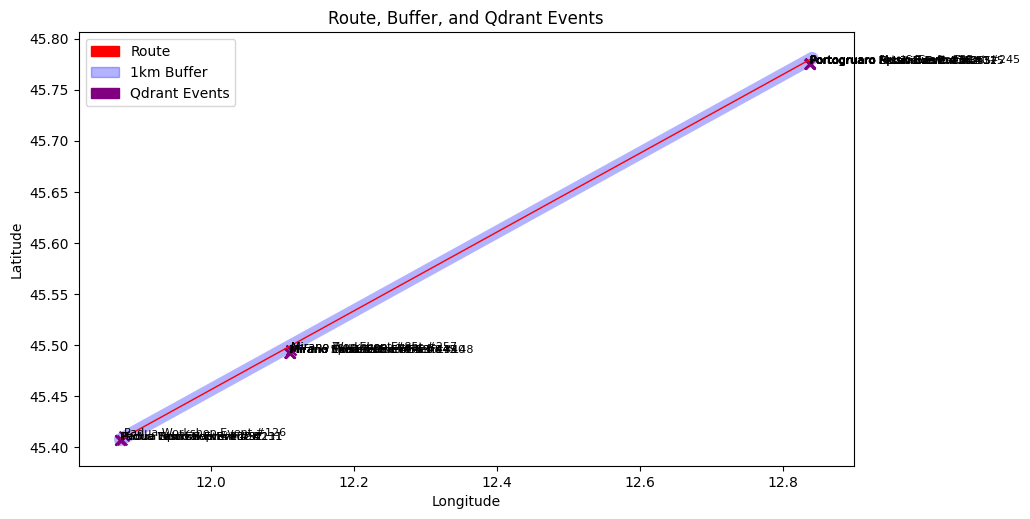

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.patches as mpatches

# Collect Qdrant results into a GeoDataFrame
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (no label here)
gpd.GeoSeries([route_line], crs="EPSG:4326").plot(ax=ax, color='red', linewidth=1)

# Plot the buffer (no label here)
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3)

# Plot Qdrant events
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50)
    # Optionally, add event titles
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

# Manually create legend patches
route_patch = mpatches.Patch(color='red', label='Route')
buffer_patch = mpatches.Patch(color='blue', alpha=0.3, label='1km Buffer')
events_patch = mpatches.Patch(color='purple', label='Qdrant Events')
ax.legend(handles=[route_patch, buffer_patch, events_patch])

ax.set_title("Route, Buffer, and Qdrant Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## I want to use Openstreetmap to create a real route

In [ ]:
%pip install osmnx

MultiDiGraph with 9944 nodes and 21419 edges
stampato G
325074361 9416572746
[325074361, 5001672068, 10819852393, 12559101771, 618643804, 618643777, 330196737, 330196268, 247911074, 1459121943, 330195233, 247906863, 330198013, 194420355, 254931559, 254931563, 254931550, 1544008135, 254931535, 254931536, 10315488615, 254931539, 254931542, 254931518, 517735773, 518014388, 517735726, 517735874, 517735554, 6697056271, 485924926, 243517142, 2310870131, 243517135, 256071918, 1834754045, 207094142, 7049685181, 255896874, 256071993, 256072058, 256072265, 762596339, 1132461607, 207093931, 521993247, 249442832, 249442864, 207096137, 210472874, 207094123, 12032040918, 465624031, 482256329, 482256334, 482256321, 729308457, 207096139, 2517681265, 263675896, 263675895, 729308463, 689585569, 729308491, 11252603899, 729308444, 729308551, 729308415, 729308494, 762106941, 677697786, 471611082, 729308468, 729308516, 729308545, 761251612, 687518445, 687518477, 260772863, 419383882, 415488489, 3936675385, 

<Axes: >

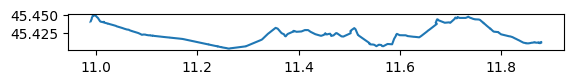

In [7]:
import osmnx as ox
from shapely.geometry import Polygon, LineString
import geopandas as gpd
import geopandas as gpd
import numpy as np
ox.settings.use_cache = True  # enable caching of HTTP requests

# Your origin and destination points (lat, lon) like (y,x)
#origin_point = (45.640317186277066, 12.241487413188237) # strada Terraglio TV
#destination_point = (45.68758465370057, 12.2562502911396) # prima di Selvana TV


origin_point = (45.41026004774276, 11.877749172855356) # Padova
destination_point = (45.44013878631641, 10.989916584327693) # Verona
#origin_point = (45.4109553303283, 11.883520063045811) # Padova (PD)
#destination_point = (45.55564536495325, 11.543093946961582) # Vicenza (VI)

#destination_point = (45.45795667928977, 10.982370142567046) # Verona (VR)
#origin_point = (45.5063774869007, 10.73446566988937) # Lazise (VR)
#destination_point =(45.43848433719987, 10.969985064989903) # Verona (VR)

# Create bounding box polygon covering both points
min_lat = min(origin_point[0], destination_point[0])
max_lat = max(origin_point[0], destination_point[0])
min_lon = min(origin_point[1], destination_point[1])
max_lon = max(origin_point[1], destination_point[1])

bbox_polygon = Polygon([
    (min_lon, min_lat),  # southwest
    (min_lon, max_lat),  # northwest
    (max_lon, max_lat),  # northeast
    (max_lon, min_lat),  # southeast
    (min_lon, min_lat)   # close polygon
])

from shapely.geometry import Polygon
bbox_polygon = bbox_polygon.buffer(0.01)  # buffer about 1 km depending on coordinates

# Download drivable road network within this polygon
G = ox.graph_from_polygon(bbox_polygon, network_type='drive', retain_all=True)
print(G)
print("stampato G")
# Find nearest nodes to origin and destination points in graph (lon, lat)
origin_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0],return_dist=False)
destination_node = ox.distance.nearest_nodes(G, destination_point[1], destination_point[0],return_dist=False)
print(origin_node,destination_node)
#origin_node=247910834
#destination_node=530212898

# Compute shortest path by length
#route = ox.shortest_path(G, origin_node, destination_node, weight='length')
route = ox.shortest_path(G, origin_node, destination_node, weight='length')
print(route)


# Extract node coordinates for route geometry
route_coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in route]

# Create a LineString for the route
route_line = LineString(route_coords)

# Create GeoDataFrame for route
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')

# Convert to projected CRS for buffering
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_poly = route_gdf_3857.buffer(1000).to_crs(epsg=4326).iloc[0]

# Extract polygon coordinates for Qdrant filter
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

print(polygon_coords_qdrant)

# Plot the route
route_gdf.plot()


In [8]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.982690964498163, 'lat': 45.446019957239905}, {'lon': 10.982708724873008, 'lat': 45.44620453816914}, {'lon': 10.982847288930863, 'lat': 45.44679683765832}, {'lon': 10.983065537414978, 'lat': 45.44737719706735}, {'lon': 10.983411637414978, 'lat': 45.44814687119577}, {'lon': 10.983678877661323, 'lat': 45.44866193701848}, {'lon': 10.984008901857294, 'lat': 45.44915875944199}, {'lon': 10.98479420120221, 'lat': 45.450218020715845}, {'lon': 10.984806168996679, 'lat': 45.45026183441387}, {'lon': 10.984973925748266, 'lat': 45.45076388390696}, {'lon': 10.98500182574827, 'lat': 45.450834281799985}, {'lon': 10.985372006673646, 'lat': 45.4515825183109}, {'lon': 10.985493006673646, 'lat': 45.45178500956397}, {'lon': 10.9858812214236, 'lat': 45.45235319681916}, {'lon': 10.986348378025367, 'lat': 45.452891343202644}, {'lon': 10.986889806269707, 'lat': 45.45339406974718}, {'lon': 10.987500093446654, 'lat': 45.45385635165833}, {'lon': 10.988173138456922, 'lat': 45.45427356850738}, {'lon': 10

,id,title,category,description,city,start_date,end_date,url,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,10,Verona Arts & Crafts Event #10,Arts & Crafts,Immerse yourself in the rich culture of Verona...,Verona,2025-09-18T03:23:00Z,2025-09-18T09:23:00Z,https://example.com/veneto-events/10,1fb3596c7adbbf0c7a1e155fa84b658a6898c1c1ba4984...,Santa Anastasia Church,"Santa Anastasia Church, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
1,111,Padua Exhibition Event #111,Exhibition,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-26T19:57:00Z,2025-09-27T04:57:00Z,https://example.com/veneto-events/111,ec4b22948e65b96db7b4a06f780ea03252347c37768648...,Abbazia di Santa Giustina,"Abbazia di Santa Giustina, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
2,208,Verona Workshop Event #208,Workshop,Dive into the world of workshop at this exciti...,Verona,2025-08-31T17:02:00Z,2025-09-01T01:02:00Z,https://example.com/veneto-events/208,65cf79d783d6a58e57c6a13a1da08e61fd32b91441c010...,Torre dei Lamberti,"Torre dei Lamberti, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
3,91,Padua Festival Event #91,Festival,Explore the vibrant festival scene in Padua wi...,Padua,2025-09-27T17:08:00Z,2025-09-28T01:08:00Z,https://example.com/veneto-events/91,7915ee163dd971efa6dab07dc161211734497c0e35b679...,Museo Antoniano,"Museo Antoniano, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
4,231,Padua Workshop Event #231,Workshop,Prepare for an unforgettable workshop experien...,Padua,2025-09-27T22:16:00Z,2025-09-28T00:16:00Z,https://example.com/veneto-events/231,41a0d445ff861968d063d2cd6c8d5324f38941f08b813e...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
5,126,Padua Workshop Event #126,Workshop,Explore the vibrant workshop scene in Padua wi...,Padua,2025-09-02T19:17:00Z,2025-09-02T23:17:00Z,https://example.com/veneto-events/126,2c2039eaf9d474957baca8bd38e51bcdc9d2721797c20d...,Museo Bottacin,"Museo Bottacin, Padua, Veneto",45.411432,11.878154,45.411432,11.878154
6,198,Padua Sport Event #198,Sport,Connect with fellow enthusiasts at this lively...,Padua,2025-09-09T20:27:00Z,2025-09-09T23:27:00Z,https://example.com/veneto-events/198,76d78442f73ada62b7820fec2e6d22b6cfcb28208a1a8e...,Piazza delle Erbe,"Piazza delle Erbe, Padua, Veneto",45.406932,11.875273,45.406932,11.875273
7,37,Padua Festival Event #37,Festival,Expand your horizons with this insightful fest...,Padua,2025-09-11T17:16:00Z,2025-09-12T01:16:00Z,https://example.com/veneto-events/37,d610fe687a16741994be38c52d9a5d738c5df039b516dc...,Museo del Precinema,"Museo del Precinema, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
8,307,Padua Tour Event #307,Tour,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-22T14:39:00Z,2025-09-22T23:39:00Z,https://example.com/veneto-events/307,f8a0703b3a784c14006b22da06e67de50dd35a5fcfeb45...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446


/tmp/ipykernel_29177/1829689547.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


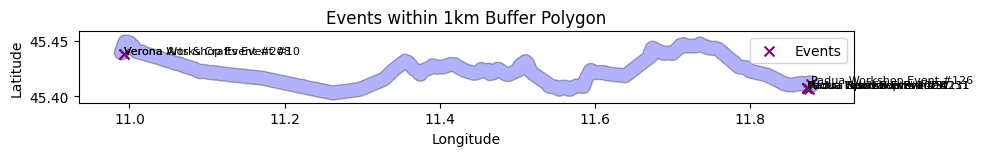

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Build gdf_qdrant from Qdrant results if not already defined
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffer polygon
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3, edgecolor='black', label='1km Buffer')

# Plot the events inside the buffer
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events')
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

ax.set_title("Events within 1km Buffer Polygon")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [ ]:
%pip install openrouteservice

In [10]:
import openrouteservice
from openrouteservice import convert
import os

from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")


# Specify your personal API key here
api_key = OPENROUTE_API_KEY

# Initialize the client with your API key
client = openrouteservice.Client(key=api_key)

# Define coordinates as a list of longitude, latitude tuples
coords = [(8.34234, 48.23424), (8.34423, 48.26424)]

# Request directions for cycling-regular profile
routes = client.directions(coords, profile='cycling-regular', optimize_waypoints=True)

# Print the raw response
print(routes)

# Decode the polyline geometry to GeoJSON format
geometry = routes['routes'][0]['geometry']
decoded = convert.decode_polyline(geometry)

# Print decoded geometry
print(decoded)


/home/biso/development/my_projects/.venv/lib/python3.12/site-packages/openrouteservice/directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


{'bbox': [8.327725, 48.233135, 8.345244, 48.263552], 'routes': [{'summary': {'distance': 5205.9, 'duration': 1305.3}, 'segments': [{'distance': 5205.9, 'duration': 1305.3, 'steps': [{'distance': 888.7, 'duration': 234.8, 'type': 11, 'instruction': 'Head southwest', 'name': '-', 'way_points': [0, 24]}, {'distance': 822.8, 'duration': 164.6, 'type': 5, 'instruction': 'Turn slight right onto Sulzbacher Straße, K 5528', 'name': 'Sulzbacher Straße, K 5528', 'way_points': [24, 52]}, {'distance': 263.7, 'duration': 59.3, 'type': 1, 'instruction': 'Turn right', 'name': '-', 'way_points': [52, 61]}, {'distance': 301.9, 'duration': 67.9, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [61, 73]}, {'distance': 535.6, 'duration': 118.0, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [73, 84]}, {'distance': 248.1, 'duration': 55.8, 'type': 13, 'instruction': 'Keep right', 'name': '-', 'way_points': [84, 92]}, {'distance': 286.6, 'duration': 73.7, 'type': 1, 'inst

## I chose openroute services because it is reliable, fast, and ok with api limits

In [13]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.982690964498163, 'lat': 45.446019957239905}, {'lon': 10.982708724873008, 'lat': 45.44620453816914}, {'lon': 10.982847288930863, 'lat': 45.44679683765832}, {'lon': 10.983065537414978, 'lat': 45.44737719706735}, {'lon': 10.983411637414978, 'lat': 45.44814687119577}, {'lon': 10.983678877661323, 'lat': 45.44866193701848}, {'lon': 10.984008901857294, 'lat': 45.44915875944199}, {'lon': 10.98479420120221, 'lat': 45.450218020715845}, {'lon': 10.984806168996679, 'lat': 45.45026183441387}, {'lon': 10.984973925748266, 'lat': 45.45076388390696}, {'lon': 10.98500182574827, 'lat': 45.450834281799985}, {'lon': 10.985372006673646, 'lat': 45.4515825183109}, {'lon': 10.985493006673646, 'lat': 45.45178500956397}, {'lon': 10.9858812214236, 'lat': 45.45235319681916}, {'lon': 10.986348378025367, 'lat': 45.452891343202644}, {'lon': 10.986889806269707, 'lat': 45.45339406974718}, {'lon': 10.987500093446654, 'lat': 45.45385635165833}, {'lon': 10.988173138456922, 'lat': 45.45427356850738}, {'lon': 10

,id,title,category,description,city,start_date,end_date,url,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,10,Verona Arts & Crafts Event #10,Arts & Crafts,Immerse yourself in the rich culture of Verona...,Verona,2025-09-18T03:23:00Z,2025-09-18T09:23:00Z,https://example.com/veneto-events/10,1fb3596c7adbbf0c7a1e155fa84b658a6898c1c1ba4984...,Santa Anastasia Church,"Santa Anastasia Church, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
1,111,Padua Exhibition Event #111,Exhibition,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-26T19:57:00Z,2025-09-27T04:57:00Z,https://example.com/veneto-events/111,ec4b22948e65b96db7b4a06f780ea03252347c37768648...,Abbazia di Santa Giustina,"Abbazia di Santa Giustina, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
2,208,Verona Workshop Event #208,Workshop,Dive into the world of workshop at this exciti...,Verona,2025-08-31T17:02:00Z,2025-09-01T01:02:00Z,https://example.com/veneto-events/208,65cf79d783d6a58e57c6a13a1da08e61fd32b91441c010...,Torre dei Lamberti,"Torre dei Lamberti, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
3,91,Padua Festival Event #91,Festival,Explore the vibrant festival scene in Padua wi...,Padua,2025-09-27T17:08:00Z,2025-09-28T01:08:00Z,https://example.com/veneto-events/91,7915ee163dd971efa6dab07dc161211734497c0e35b679...,Museo Antoniano,"Museo Antoniano, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
4,231,Padua Workshop Event #231,Workshop,Prepare for an unforgettable workshop experien...,Padua,2025-09-27T22:16:00Z,2025-09-28T00:16:00Z,https://example.com/veneto-events/231,41a0d445ff861968d063d2cd6c8d5324f38941f08b813e...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
5,126,Padua Workshop Event #126,Workshop,Explore the vibrant workshop scene in Padua wi...,Padua,2025-09-02T19:17:00Z,2025-09-02T23:17:00Z,https://example.com/veneto-events/126,2c2039eaf9d474957baca8bd38e51bcdc9d2721797c20d...,Museo Bottacin,"Museo Bottacin, Padua, Veneto",45.411432,11.878154,45.411432,11.878154
6,198,Padua Sport Event #198,Sport,Connect with fellow enthusiasts at this lively...,Padua,2025-09-09T20:27:00Z,2025-09-09T23:27:00Z,https://example.com/veneto-events/198,76d78442f73ada62b7820fec2e6d22b6cfcb28208a1a8e...,Piazza delle Erbe,"Piazza delle Erbe, Padua, Veneto",45.406932,11.875273,45.406932,11.875273
7,37,Padua Festival Event #37,Festival,Expand your horizons with this insightful fest...,Padua,2025-09-11T17:16:00Z,2025-09-12T01:16:00Z,https://example.com/veneto-events/37,d610fe687a16741994be38c52d9a5d738c5df039b516dc...,Museo del Precinema,"Museo del Precinema, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
8,307,Padua Tour Event #307,Tour,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-22T14:39:00Z,2025-09-22T23:39:00Z,https://example.com/veneto-events/307,f8a0703b3a784c14006b22da06e67de50dd35a5fcfeb45...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446


## Update 26/08/2025
## Now I query with prefecthes and filter


In [39]:
#import pandas as pd
import openrouteservice
#from qdrant_client.models import FieldCondition, Range, Filter
import os
from dotenv import load_dotenv
from fastembed import TextEmbedding, SparseTextEmbedding
from qdrant_client import QdrantClient, models
from shapely.geometry import LineString
#import geopandas as gpd
import time
import functools


load_dotenv(dotenv_path="../.env")
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = os.getenv("COLLECTION_NAME")
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

DENSE_MODEL_NAME = os.getenv("DENSE_MODEL_NAME")   # e.g. "BAAI/bge-small-en-v1.5"
SPARSE_MODEL_NAME = os.getenv("SPARSE_MODEL_NAME") # e.g. "Qdrant/bm25"

if not QDRANT_SERVER or not QDRANT_API_KEY:
    raise ValueError("QDRANT_SERVER or QDRANT_API_KEY not defined in .env file")
dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)
sparse_embedding_model = SparseTextEmbedding(SPARSE_MODEL_NAME)

dense_vector_name = "dense_vector"
sparse_vector_name = "sparse_vector"
client = QdrantClient(url=QDRANT_SERVER, api_key=QDRANT_API_KEY, timeout=200000, https=False)

import time
import functools


# Timer decorator to measure any function
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Function {func.__name__!r} executed in {run_time:.4f} seconds")
        return value
    return wrapper_timer



@timer
def geocode_address(address):
    geocode_result = ors_client.pelias_search(text=address)
    if geocode_result and 'features' in geocode_result and len(geocode_result['features']) > 0:
        coords = geocode_result['features'][0]['geometry']['coordinates']  # [lon, lat]
        return tuple(coords)
    else:
        raise ValueError(f"Could not geocode address: {address}")

@timer
def create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date):
    origin = geocode_address(origin_address)
    destination = geocode_address(destination_address)
    coords = [origin, destination]
    radiuses = [1000, 1000]  # buffering route ends roughly by 1 km radius

    # Timing directions API call
    start_directions = time.perf_counter()
    routes = ors_client.directions(coordinates=coords, profile='driving-car', radiuses=radiuses, format='geojson')
    end_directions = time.perf_counter()
    print(f"Directions API call took {end_directions - start_directions:.4f} seconds")

    # buffer creation timing manually added
    start_buffer = time.perf_counter()
    route_coords = routes['features'][0]['geometry']['coordinates']
    route_line = LineString(route_coords)
    route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')
    route_gdf_3857 = route_gdf.to_crs(epsg=3857)  # project to meters
    buffer_polygon = route_gdf_3857.buffer(buffer_distance_km * 1000).to_crs(epsg=4326).iloc[0]
    end_buffer = time.perf_counter()
    print(f"Buffer creation took {end_buffer - start_buffer:.4f} seconds")

    polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
    qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

    geo_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    )
    date_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="start_date",
                range=models.DatetimeRange(lte=end_date)
            ),
            models.FieldCondition(
                key="end_date",
                range=models.DatetimeRange(gte=start_date)
            )
        ]
    )
    final_filter = models.Filter(
        must=geo_filter.must + date_filter.must
    )
    return final_filter


@timer
def query_qdrant(query_text):
    return client.query_points(
        collection_name=COLLECTION_NAME,
        prefetch=[
            models.Prefetch(
                query=models.SparseVector(
                    indices=list(list(sparse_embedding_model.passage_embed([query_text]))[0].indices),
                    values=list(list(sparse_embedding_model.passage_embed([query_text]))[0].values)
                ),
                using=sparse_vector_name,
                limit=50,
            ),
            models.Prefetch(
                query=list(dense_embedding_model.passage_embed([query_text]))[0].tolist(),
                using=dense_vector_name,
                limit=50,
            ),
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
        query_filter=final_filter,
        limit=10,
        with_payload=True,
    )



@timer
def process_results(results):
    records = []
    for point in results.points:
        entry = dict(point.payload)
        entry["score"] = point.score
        records.append(entry)

    df = pd.json_normalize(records)

    cols = list(df.columns)
    if "score" in cols:
        cols.remove("score")
        cols.insert(1, "score")
    if "price.value" in cols:
        cols.remove("price.value")
        cols.remove("price_value")
        cols.insert(2, "price.value")
    df = df[cols]
    return df

/tmp/ipykernel_9656/637375689.py:26: UserWarning: The model sentence-transformers/paraphrase-multilingual-mpnet-base-v2 now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)


In [40]:
import pandas as pd
import geopandas as gpd
import numpy as np
import time



query_text = ""
origin_address = "285 Northgate Drive, Warrendale"
destination_address = "6915 Cass St, Omaha"
buffer_distance_km = 15
start_date = "2026-01-01T15:32:00Z"
end_date = "2026-04-05T15:34:00Z"



# Timing embedding steps separately
start_dense_embed = time.perf_counter()

end_dense_embed = time.perf_counter()
print(f"Dense embedding took {end_dense_embed - start_dense_embed:.4f} seconds")

start_sparse_embed = time.perf_counter()

end_sparse_embed = time.perf_counter()
print(f"Sparse embedding took {end_sparse_embed - start_sparse_embed:.4f} seconds")

final_filter = create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date)


results = query_qdrant(query_text)

df = process_results(results)
df


Dense embedding took 0.0000 seconds
Sparse embedding took 0.0000 seconds
Function 'geocode_address' executed in 0.8024 seconds
Function 'geocode_address' executed in 0.8024 seconds
Function 'geocode_address' executed in 0.5259 seconds
Function 'geocode_address' executed in 0.5259 seconds
Directions API call took 11.4106 seconds
Directions API call took 11.4106 seconds
Buffer creation took 0.2343 seconds
Function 'create_route_buffer_filter' executed in 13.3046 seconds
Buffer creation took 0.2343 seconds
Function 'create_route_buffer_filter' executed in 13.3046 seconds
Function 'query_qdrant' executed in 3.7394 seconds
Function 'process_results' executed in 0.0011 seconds
Function 'query_qdrant' executed in 3.7394 seconds
Function 'process_results' executed in 0.0011 seconds


""


### Choosing the profile driving car or bike

In [1]:
import pandas as pd
import openrouteservice
import re
from qdrant_client.models import FieldCondition, Range, Filter
import os
from dotenv import load_dotenv
from fastembed import TextEmbedding, SparseTextEmbedding
from qdrant_client import QdrantClient, models
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np


# Load environment variables
load_dotenv(dotenv_path="../.env")
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# Initialize OpenRouteService client
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

# Load embedding model names from env
DENSE_MODEL_NAME = os.getenv("DENSE_MODEL_NAME")   # e.g. "BAAI/bge-small-en-v1.5"
SPARSE_MODEL_NAME = os.getenv("SPARSE_MODEL_NAME") # e.g. "Qdrant/bm25"

if not QDRANT_SERVER or not QDRANT_API_KEY:
    raise ValueError("QDRANT_SERVER or QDRANT_API_KEY not defined in .env file")

# Initialize embedding clients
dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)
sparse_embedding_model = SparseTextEmbedding(SPARSE_MODEL_NAME)

dense_vector_name = "dense_vector"
sparse_vector_name = "sparse_vector"
COLLECTION_NAME = os.getenv("COLLECTION_NAME") #"veneto_events"

# Initialize Qdrant client
client = QdrantClient(url=QDRANT_SERVER, api_key=QDRANT_API_KEY, timeout=200000, https=False)


def create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date, profile='driving-car'):
    # Geocode address to (lon, lat)
    def geocode_address(address):
        geocode_result = ors_client.pelias_search(text=address)
        if geocode_result and 'features' in geocode_result and len(geocode_result['features']) > 0:
            coords = geocode_result['features'][0]['geometry']['coordinates']  # [lon, lat]
            return tuple(coords)
        else:
            raise ValueError(f"Could not geocode address: {address}")

    # Get route points between origin and destination
    origin = geocode_address(origin_address)
    destination = geocode_address(destination_address)
    coords = [origin, destination]
    radiuses = [1000, 1000]  # buffering route ends roughly by 1 km radius
    routes = ors_client.directions(
        coordinates=coords,
        profile=profile,
        radiuses=radiuses,
        format='geojson'
    )
    route_coords = routes['features'][0]['geometry']['coordinates']

    # Create route line and buffer polygon
    route_line = LineString(route_coords)
    route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')
    route_gdf_3857 = route_gdf.to_crs(epsg=3857)  # project to meters
    buffer_polygon = route_gdf_3857.buffer(buffer_distance_km * 1000).to_crs(epsg=4326).iloc[0]

    # Prepare polygon coordinates for Qdrant geo filter (list of lon-lat dicts)
    polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
    qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

    # Build Qdrant filters
    geo_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    )
    date_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="start_date",
                range=models.DatetimeRange(lte=end_date)
            ),
            models.FieldCondition(
                key="end_date",
                range=models.DatetimeRange(gte=start_date)
            )
        ]
    )

    # Combine filters into a final filter with must conditions
    final_filter = models.Filter(
        must=geo_filter.must + date_filter.must
    )

    return final_filter




/tmp/ipykernel_38179/1950300154.py:31: UserWarning: The model sentence-transformers/paraphrase-multilingual-mpnet-base-v2 now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)


In [2]:
# Parameters (can be adjusted dynamically)
query_text = "Davis"
origin_address = "285 Northgate Drive, Warrendale" #"Venezia"
destination_address = "6915 Cass St, Omaha" #"Verona"
buffer_distance_km = 15
start_date = "2026-02-05T15:32:00Z"
end_date = "2026-02-08T15:34:00Z"
profile_choice = 'driving-car'  # 'driving-car' or 'cycling-regular', 'foot-walking', etc.

score_treshold = 0.0
if query_text.strip() == "":
    score_treshold = 0.0  # No text query, so no score threshold
else:
    score_treshold = 0.34  # Adjust based on desired relevance

# Embed query text to dense vector
query_dense_vector = list(dense_embedding_model.passage_embed([query_text]))[0].tolist()
# Embed query text to sparse vector
query_sparse_embedding = list(sparse_embedding_model.passage_embed([query_text]))[0]

# Create filter with route buffer (GEO ONLY - date filtering will be done in Python)
final_filter = create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date, profile=profile_choice)

# NOTE: create_route_buffer_filter returns both geo AND date filters, but date filters don't work reliably in Qdrant
# So we'll use GEO ONLY and filter by date in Python below
geo_only_filter = models.Filter(must=[final_filter.must[0]])  # Only keep the geo filter

# Perform hybrid query with prefetches for dense and sparse vectors using RRF fusion
results = client.query_points(
    collection_name=COLLECTION_NAME,
    prefetch=[
        models.Prefetch(
            query=models.SparseVector(
                indices=list(query_sparse_embedding.indices),
                values=list(query_sparse_embedding.values)
            ),
            using=sparse_vector_name,
            limit=50,
            #score_threshold=score_treshold,  # Optional: filter out low-score results
        ),
        models.Prefetch(
            query=query_dense_vector,
            using=dense_vector_name,
            limit=50,
            score_threshold=score_treshold,  # Optional: filter out low-score results
        ),
    ],
    query=models.FusionQuery(fusion=models.Fusion.RRF),
    query_filter=geo_only_filter,  # Use GEO filter only
    limit=200,  # Get more results to filter by date
    with_payload=True,
)

# Filter results by date range in Python (workaround for Qdrant datetime indexing)
from datetime import datetime

query_start_dt = datetime.fromisoformat(start_date.replace('Z', '+00:00'))
query_end_dt = datetime.fromisoformat(end_date.replace('Z', '+00:00'))

def is_event_in_date_range(event_start_str, event_end_str, q_start, q_end):
    """Check if event time overlaps with query time range"""
    try:
        event_start = datetime.fromisoformat(event_start_str.replace('Z', '+00:00'))
        event_end = datetime.fromisoformat(event_end_str.replace('Z', '+00:00'))
        # Events overlap if: event_end >= query_start AND event_start <= query_end
        return event_end >= q_start and event_start <= q_end
    except:
        return False

# Process results into dataframe with date filtering
records = []
for point in results.points:
    # Apply date filter
    if not is_event_in_date_range(
        point.payload.get('start_date', ''),
        point.payload.get('end_date', ''),
        query_start_dt,
        query_end_dt
    ):
        continue
    
    entry = dict(point.payload)
    entry["score"] = point.score
    records.append(entry)

df = pd.json_normalize(records)

# Reorder columns to put 'score' as second column if exists and price.value
cols = list(df.columns)
if "score" in cols:
    cols.remove("score")
    cols.insert(1, "score")
df = df[cols]

df


,id,score,title,category,description,city,start_date,end_date,url,credits,delta_type,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,7589050,0.750000,DeRay Davis,Concerts > Comedy,DeRay Davis,Omaha,2026-02-06T09:45Z,2026-02-06T23:59:59Z,https://www.ticketsqueeze.com/tickets/7589050/...,TicketSqueeze - Events Data,added,33db86eab4bc888a06b9c7de464e316aba3f8f76d8cb0c...,Funny Bone Comedy Club - Omaha,17305 Davenport St.,41.260681,-96.185615,41.260681,-96.185615
1,7589049,0.700000,DeRay Davis,Concerts > Comedy,DeRay Davis,Omaha,2026-02-06T07:00Z,2026-02-06T23:59:59Z,https://www.ticketsqueeze.com/tickets/7589049/...,TicketSqueeze - Events Data,added,33db86eab4bc888a06b9c7de464e316aba3f8f76d8cb0c...,Funny Bone Comedy Club - Omaha,17305 Davenport St.,41.260681,-96.185615,41.260681,-96.185615
2,7589052,0.583333,DeRay Davis,Concerts > Comedy,DeRay Davis,Omaha,2026-02-07T09:15Z,2026-02-07T23:59:59Z,https://www.ticketsqueeze.com/tickets/7589052/...,TicketSqueeze - Events Data,added,33db86eab4bc888a06b9c7de464e316aba3f8f76d8cb0c...,Funny Bone Comedy Club - Omaha,17305 Davenport St.,41.260681,-96.185615,41.260681,-96.185615
3,7589051,0.533333,DeRay Davis,Concerts > Comedy,DeRay Davis,Omaha,2026-02-07T06:30Z,2026-02-07T23:59:59Z,https://www.ticketsqueeze.com/tickets/7589051/...,TicketSqueeze - Events Data,added,33db86eab4bc888a06b9c7de464e316aba3f8f76d8cb0c...,Funny Bone Comedy Club - Omaha,17305 Davenport St.,41.260681,-96.185615,41.260681,-96.185615


In [6]:
# Parameters (can be adjusted dynamically)
query_text = "Davis"
origin_address = "285 Northgate Drive, Warrendale"
destination_address = "6915 Cass St, Omaha"
buffer_distance_km = 15
start_date = "2026-02-05T15:32:00Z"
end_date = "2026-02-08T15:34:00Z"
profile_choice = 'driving-car'

score_threshold = 0.0
if query_text.strip() == "":
    score_threshold = 0.0
else:
    score_threshold = 0.34

# Embed query text
query_dense_vector = list(dense_embedding_model.passage_embed([query_text]))[0].tolist()
query_sparse_embedding = list(sparse_embedding_model.passage_embed([query_text]))[0]

# ✅ Get GEO filter from route buffer (first must condition)
route_filter = create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date, profile=profile_choice)
geo_filter = models.Filter(must=[route_filter.must[0]])  # Extract GEO only

# ✅ Build DATE filter (qdrant_service.py pattern)
date_filter = models.Filter(
    must=[
        models.FieldCondition(
            key="start_date",
            range=models.DatetimeRange(lte=end_date)
        ),
        models.FieldCondition(
            key="end_date",
            range=models.DatetimeRange(gte=start_date)
        )
    ]
)

# ✅ Combine GEO + DATE filters
final_filter = models.Filter(must=geo_filter.must + date_filter.must)

# ✅ Hybrid query with FULL Qdrant filtering (qdrant_service.py pattern)
results = client.query_points(
    collection_name=COLLECTION_NAME,
    prefetch=[
        models.Prefetch(
            query=models.SparseVector(
                indices=list(query_sparse_embedding.indices),
                values=list(query_sparse_embedding.values)
            ),
            using=sparse_vector_name,  # Fixed: use your constants
            limit=50,
        ),
        models.Prefetch(
            query=query_dense_vector,
            using=dense_vector_name,   # Fixed: use your constants
            limit=50,
            score_threshold=score_threshold,
        ),
    ],
    query=models.FusionQuery(fusion=models.Fusion.RRF),
    query_filter=final_filter,  # ✅ GEO + DATE in Qdrant!
    limit=200,
    with_payload=True,
)

# ✅ NO Python date filtering needed! Direct processing
records = []
for point in results.points:
    entry = dict(point.payload)
    entry["score"] = point.score
    records.append(entry)

df = pd.json_normalize(records)

# Reorder columns
cols = list(df.columns)
if "score" in cols:
    cols.remove("score")
    cols.insert(1, "score")
df = df[cols]

df


""


In [19]:
# Debug: Print calculated coordinates and polygon
print("\n=== ROUTE BUFFER DEBUG ===")
print(f"Origin address: {origin_address}")
print(f"Destination address: {destination_address}")

# Recreate the route to inspect intermediate values
from shapely.geometry import LineString
import geopandas as gpd

origin = ors_client.pelias_search(text=origin_address)['features'][0]['geometry']['coordinates']
destination = ors_client.pelias_search(text=destination_address)['features'][0]['geometry']['coordinates']
print(f"Origin coordinates (lon, lat): {origin}")
print(f"Destination coordinates (lon, lat): {destination}")

coords = [origin, destination]
routes = ors_client.directions(coordinates=coords, profile=profile_choice, radiuses=[1000, 1000], format='geojson')
route_coords = routes['features'][0]['geometry']['coordinates']
print(f"Route has {len(route_coords)} points")
print(f"First route point (lon, lat): {route_coords[0]}")
print(f"Last route point (lon, lat): {route_coords[-1]}")

# Buffer
route_line = LineString(route_coords)
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_polygon = route_gdf_3857.buffer(buffer_distance_km * 1000).to_crs(epsg=4326).iloc[0]

polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
print(f"Buffer polygon has {len(polygon_coords)} boundary points")
print(f"Sample polygon points (lon, lat):")
for i in [0, len(polygon_coords)//2, -1]:
    print(f"  Point {i}: {polygon_coords[i]}")

print("=== END DEBUG ===\n")


=== ROUTE BUFFER DEBUG ===
Origin address: 285 Northgate Drive, Warrendale
Destination address: 17305 Davenport St., Omaha
Origin coordinates (lon, lat): [-122.01564, 45.61262]
Destination coordinates (lon, lat): [-96.185836, 41.260403]
Origin coordinates (lon, lat): [-122.01564, 45.61262]
Destination coordinates (lon, lat): [-96.185836, 41.260403]
Route has 9959 points
First route point (lon, lat): [-122.015568, 45.612383]
Last route point (lon, lat): [-96.185804, 41.260284]
Buffer polygon has 13085 boundary points
Sample polygon points (lon, lat):
  Point 0: [-122.11802155880844, 45.68125886349071]
  Point 6542: [-96.04228672798487, 41.22397056343344]
  Point -1: [-122.11802155880844, 45.68125886349071]
=== END DEBUG ===

Route has 9959 points
First route point (lon, lat): [-122.015568, 45.612383]
Last route point (lon, lat): [-96.185804, 41.260284]
Buffer polygon has 13085 boundary points
Sample polygon points (lon, lat):
  Point 0: [-122.11802155880844, 45.68125886349071]
  Point 

In [21]:
# Check if the Mojo Brookzz event's location is within the buffer polygon
from shapely.geometry import Point

event_location = Point(-96.1856151, 41.2606808)  # Omaha venue (lon, lat)

print(f"Event location: {event_location}")
print(f"Buffer polygon contains event: {buffer_polygon.contains(event_location)}")
print(f"Event is within buffer bounds: {event_location.within(buffer_polygon)}")

# Also check the distance from the event to the route
from shapely.geometry import LineString
route_line_test = LineString(route_coords)
distance_to_route = route_line_test.distance(event_location)
print(f"Distance from event to route (degrees): {distance_to_route}")
print(f"Distance from event to route (approx km): {distance_to_route * 111}")  # rough conversion

# Print buffer boundaries
print(f"\nBuffer polygon bounds: {buffer_polygon.bounds}")
print(f"Event coordinates: lon={event_location.x}, lat={event_location.y}")


Event location: POINT (-96.1856151 41.2606808)
Buffer polygon contains event: True
Event is within buffer bounds: True
Distance from event to route (degrees): 0.00038205424948117937
Distance from event to route (approx km): 0.04240802169241091

Buffer polygon bounds: (-122.18239319686273, 40.566889970297694, -96.02179360480775, 45.934211753807)
Event coordinates: lon=-96.1856151, lat=41.2606808


In [23]:
# Regenerate polygon coords if needed
polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

# Query Qdrant directly with JUST the geo filter (no date filter, no text search)
results_geo_only = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    ),
    limit=200,
    with_payload=True,
)

print(f"Events found with GEO filter only: {len(results_geo_only.points)}")

# Search for the specific event by title
mojo_events = [p for p in results_geo_only.points if "Mojo" in p.payload.get("title", "")]
print(f"Mojo events in geo results: {len(mojo_events)}")
if mojo_events:
    for p in mojo_events:
        print(f"  - {p.payload.get('title')}")
        print(f"    Location: {p.payload.get('location')}")
        print(f"    Start: {p.payload.get('start_date')}")
        print(f"    End: {p.payload.get('end_date')}")

# Now add date filter
results_geo_date = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=final_filter,  # This includes both geo AND date
    limit=200,
    with_payload=True,
)

print(f"\nEvents found with GEO + DATE filter: {len(results_geo_date.points)}")
mojo_events2 = [p for p in results_geo_date.points if "Mojo" in p.payload.get("title", "")]
print(f"Mojo events in geo+date results: {len(mojo_events2)}")
if mojo_events2:
    for p in mojo_events2:
        print(f"  - {p.payload.get('title')}")


Events found with GEO filter only: 51
Mojo events in geo results: 5
  - Mojo Brookzz
    Location: {'venue': 'Funny Bone Comedy Club - Omaha', 'address': '17305 Davenport St.', 'latitude': 41.2606808, 'longitude': -96.1856151, 'lat': 41.2606808, 'lon': -96.1856151}
    Start: 2026-06-13T09:15Z
    End: 2026-06-13T23:59:59Z
  - Mojo Brookzz
    Location: {'venue': 'Funny Bone Comedy Club - Omaha', 'address': '17305 Davenport St.', 'latitude': 41.2606808, 'longitude': -96.1856151, 'lat': 41.2606808, 'lon': -96.1856151}
    Start: 2026-06-12T09:45Z
    End: 2026-06-12T23:59:59Z
  - Mojo Brookzz
    Location: {'venue': 'Funny Bone Comedy Club - Omaha', 'address': '17305 Davenport St.', 'latitude': 41.2606808, 'longitude': -96.1856151, 'lat': 41.2606808, 'lon': -96.1856151}
    Start: 2026-06-12T07:00Z
    End: 2026-06-12T23:59:59Z
  - Mojo Brookzz
    Location: {'venue': 'Funny Bone Comedy Club - Omaha', 'address': '17305 Davenport St.', 'latitude': 41.2606808, 'longitude': -96.1856151, 'l

In [26]:
# Debug the final_filter structure (simplified)
print("Final filter must conditions:")
for i, condition in enumerate(final_filter.must):
    print(f"  Condition {i}: {condition}")

# Check the date values
print(f"\nQuery date range:")
print(f"  start_date: {start_date}")
print(f"  end_date: {end_date}")

print(f"\nEvent date range:")
print(f"  start_date: 2026-06-13T09:15Z")
print(f"  end_date: 2026-06-13T23:59:59Z")

# Test with corrected date logic
# The filter should check: event.end_date >= query.start_date AND event.start_date <= query.end_date
test_filter = models.Filter(
    must=[
        models.FieldCondition(
            key="start_date",
            range=models.DatetimeRange(lte=end_date)
        ),
        models.FieldCondition(
            key="end_date",
            range=models.DatetimeRange(gte=start_date)
        )
    ]
)

print("\n\nTesting with DATE ONLY filter:")
results_date_only = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=test_filter,
    limit=200,
    with_payload=True,
)
print(f"Events found: {len(results_date_only.points)}")
mojo_date = [p for p in results_date_only.points if "Mojo" in p.payload.get("title", "")]
print(f"Mojo events: {len(mojo_date)}")


Final filter must conditions:
  Condition 0: key='location' match=None range=None geo_bounding_box=None geo_radius=None geo_polygon=GeoPolygon(exterior=GeoLineString(points=[GeoPoint(lon=-122.11802155880844, lat=45.68125886349071), GeoPoint(lon=-122.11611498372089, lat=45.68228706182713), GeoPoint(lon=-122.11548198372088, lat=45.68261761630522), GeoPoint(lon=-122.10901377789789, lat=45.68579296003081), GeoPoint(lon=-122.10673877789789, lat=45.6868414872106), GeoPoint(lon=-122.10251521796003, lat=45.68871041341188), GeoPoint(lon=-122.10117921796002, lat=45.68927759772437), GeoPoint(lon=-122.09829956505381, lat=45.69046617009023), GeoPoint(lon=-122.09678356505385, lat=45.69107428259241), GeoPoint(lon=-122.0902832345128, lat=45.69351878762815), GeoPoint(lon=-122.0881682345128, lat=45.69426266940976), GeoPoint(lon=-122.07988998838059, lat=45.69693291199452), GeoPoint(lon=-122.07906898838057, lat=45.69717453722019), GeoPoint(lon=-122.07383302779733, lat=45.69862623736681), GeoPoint(lon=-122

In [28]:
# Simple test: combine geo + date filters properly
geo_filter = models.Filter(
    must=[
        models.FieldCondition(
            key="location",
            geo_polygon=models.GeoPolygon(
                exterior=models.GeoLineString(points=qdrant_polygon_coords)
            )
        )
    ]
)

date_filter = models.Filter(
    must=[
        models.FieldCondition(
            key="start_date",
            range=models.DatetimeRange(lte=end_date)
        ),
        models.FieldCondition(
            key="end_date",
            range=models.DatetimeRange(gte=start_date)
        )
    ]
)

# COMBINE CORRECTLY - merge the must conditions
combined_filter = models.Filter(must=geo_filter.must + date_filter.must)

print(f"Geo filter must count: {len(geo_filter.must)}")
print(f"Date filter must count: {len(date_filter.must)}")
print(f"Combined filter must count: {len(combined_filter.must)}")

# Now query with this combined filter
results_combined = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=combined_filter,
    limit=200,
    with_payload=True,
)

print(f"\nEvents found with combined filter: {len(results_combined.points)}")
mojo_combined = [p for p in results_combined.points if "Mojo" in p.payload.get("title", "")]
print(f"Mojo events: {len(mojo_combined)}")
if mojo_combined:
    for p in mojo_combined[:2]:  # Show first 2
        print(f"  - {p.payload.get('title')} | Start: {p.payload.get('start_date')} | End: {p.payload.get('end_date')}")


Geo filter must count: 1
Date filter must count: 2
Combined filter must count: 3

Events found with combined filter: 0
Mojo events: 0


In [29]:
# Check what final_filter contains
print(f"final_filter.must length: {len(final_filter.must)}")
print(f"final_filter type: {type(final_filter)}")

# Print each condition
for i, cond in enumerate(final_filter.must):
    print(f"\nCondition {i}:")
    if hasattr(cond, 'key'):
        print(f"  Key: {cond.key}")
    if hasattr(cond, 'geo_polygon'):
        print(f"  Has geo_polygon: {cond.geo_polygon is not None}")
    if hasattr(cond, 'range'):
        print(f"  Has range: {cond.range is not None}")
        if cond.range:
            print(f"    Range: {cond.range}")

# Test the geo filter alone vs the combination
print("\n\n=== Testing filters separately ===")

# Only geo
geo_only = models.Filter(must=[final_filter.must[0]])
results_geo = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=geo_only,
    limit=20,
    with_payload=False,
)
print(f"GEO only: {len(results_geo.points)} events")

# Only date (must[1] and must[2])
if len(final_filter.must) > 1:
    date_only = models.Filter(must=[final_filter.must[1], final_filter.must[2]])
    results_date = client.query_points(
        collection_name=COLLECTION_NAME,
        query_filter=date_only,
        limit=20,
        with_payload=False,
    )
    print(f"DATE only: {len(results_date.points)} events")

# Both combined
results_both = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=final_filter,
    limit=20,
    with_payload=False,
)
print(f"GEO + DATE: {len(results_both.points)} events")


final_filter.must length: 3
final_filter type: <class 'qdrant_client.http.models.models.Filter'>

Condition 0:
  Key: location
  Has geo_polygon: True
  Has range: False

Condition 1:
  Key: start_date
  Has geo_polygon: False
  Has range: True
    Range: lt=None gt=None gte=None lte=datetime.datetime(2026, 6, 14, 15, 34, tzinfo=TzInfo(UTC))

Condition 2:
  Key: end_date
  Has geo_polygon: False
  Has range: True
    Range: lt=None gt=None gte=datetime.datetime(2026, 6, 12, 15, 32, tzinfo=TzInfo(UTC)) lte=None


=== Testing filters separately ===
GEO only: 20 events
DATE only: 0 events
GEO + DATE: 0 events


In [30]:
# Get a sample event to check the actual date format in Qdrant
sample = client.query_points(
    collection_name=COLLECTION_NAME,
    limit=1,
    with_payload=True,
)

if sample.points:
    sample_event = sample.points[0].payload
    print("Sample event from Qdrant:")
    print(f"  start_date: {sample_event.get('start_date')} (type: {type(sample_event.get('start_date'))})")
    print(f"  end_date: {sample_event.get('end_date')} (type: {type(sample_event.get('end_date'))})")

# Get the mojo event specifically to see its dates
mojo_raw = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    ),
    limit=200,
    with_payload=True,
)

mojo_event = [p for p in mojo_raw.points if "Mojo" in p.payload.get("title", "")][0]
print("\n\nMojo event from Qdrant:")
print(f"  start_date: {repr(mojo_event.payload.get('start_date'))}")
print(f"  end_date: {repr(mojo_event.payload.get('end_date'))}")
print(f"  Type: {type(mojo_event.payload.get('start_date'))}")

# Test if the strings are parseable as datetime
from datetime import datetime
try:
    sd = datetime.fromisoformat(mojo_event.payload.get('start_date').replace('Z', '+00:00'))
    ed = datetime.fromisoformat(mojo_event.payload.get('end_date').replace('Z', '+00:00'))
    print(f"\nParsed dates:")
    print(f"  start_date: {sd}")
    print(f"  end_date: {ed}")
    print(f"  Query range: {start_date} to {end_date}")
except Exception as e:
    print(f"Error parsing: {e}")


Sample event from Qdrant:
  start_date: 2026-02-24T07:00Z (type: <class 'str'>)
  end_date: 2026-02-24T23:59:59Z (type: <class 'str'>)


Mojo event from Qdrant:
  start_date: '2026-06-13T09:15Z'
  end_date: '2026-06-13T23:59:59Z'
  Type: <class 'str'>

Parsed dates:
  start_date: 2026-06-13 09:15:00+00:00
  end_date: 2026-06-13 23:59:59+00:00
  Query range: 2026-06-12T15:32:00Z to 2026-06-14T15:34:00Z


In [33]:
# Create datetime indexes for start_date and end_date fields
print("Creating payload indexes for start_date and end_date...")

try:
    client.create_payload_index(
        collection_name=COLLECTION_NAME,
        field_name="start_date",
        field_schema=models.PayloadSchemaType.DATETIME,
    )
    print("✓ Created index for start_date")
except Exception as e:
    print(f"✗ Error creating start_date index: {e}")

try:
    client.create_payload_index(
        collection_name=COLLECTION_NAME,
        field_name="end_date",
        field_schema=models.PayloadSchemaType.DATETIME,
    )
    print("✓ Created index for end_date")
except Exception as e:
    print(f"✗ Error creating end_date index: {e}")

# Now test the date filter again
print("\n\nTesting date filter after creating indexes...")
date_test_filter = models.Filter(
    must=[
        models.FieldCondition(
            key="start_date",
            range=models.DatetimeRange(lte=end_date)
        ),
        models.FieldCondition(
            key="end_date",
            range=models.DatetimeRange(gte=start_date)
        )
    ]
)

results_date_test = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=date_test_filter,
    limit=50,
    with_payload=True,
)

print(f"Events found with DATE filter: {len(results_date_test.points)}")
mojo_date_test = [p for p in results_date_test.points if "Mojo" in p.payload.get("title", "")]
print(f"Mojo events found: {len(mojo_date_test)}")
if mojo_date_test:
    for p in mojo_date_test[:2]:
        print(f"  - {p.payload.get('title')} | {p.payload.get('start_date')} to {p.payload.get('end_date')}")


Creating payload indexes for start_date and end_date...
✓ Created index for start_date
✓ Created index for end_date


Testing date filter after creating indexes...
✓ Created index for start_date
✓ Created index for end_date


Testing date filter after creating indexes...
Events found with DATE filter: 0
Mojo events found: 0
Events found with DATE filter: 0
Mojo events found: 0


In [34]:
# Debug: Check raw point data from Qdrant
import json

# Get one event from geo filter
single_event_results = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    ),
    limit=1,
    with_payload=True,
)

if single_event_results.points:
    point = single_event_results.points[0]
    print("Raw point payload keys:", list(point.payload.keys()))
    print(f"\nstart_date: {repr(point.payload.get('start_date'))}")
    print(f"end_date: {repr(point.payload.get('end_date'))}")
    print(f"Types: start_date={type(point.payload.get('start_date'))}, end_date={type(point.payload.get('end_date'))}")

# The problem: Qdrant datetime fields expect ISO format WITHOUT 'Z' suffix
# Let's check if dates need to be stored differently
print("\n\nTesting different datetime formats...")

# Try with datetime object instead of string
from datetime import datetime

test_dt_string = "2026-06-13T09:15Z"
test_dt_obj = datetime.fromisoformat(test_dt_string.replace('Z', '+00:00'))

print(f"String format: {test_dt_string}")
print(f"Datetime object: {test_dt_obj}")
print(f"ISO format (no Z): {test_dt_obj.isoformat()}")
print(f"ISO format (with Z): {test_dt_obj.isoformat().replace('+00:00', 'Z')}")

# Qdrant might expect timestamps without the Z
print(f"\nTrying filter with ISO format (no Z)...")
alt_start = "2026-06-12T15:32:00+00:00"
alt_end = "2026-06-14T15:34:00+00:00"

try:
    alt_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="start_date",
                range=models.DatetimeRange(lte=alt_end)
            ),
            models.FieldCondition(
                key="end_date",
                range=models.DatetimeRange(gte=alt_start)
            )
        ]
    )
    alt_results = client.query_points(
        collection_name=COLLECTION_NAME,
        query_filter=alt_filter,
        limit=10,
        with_payload=False,
    )
    print(f"Results with +00:00 format: {len(alt_results.points)}")
except Exception as e:
    print(f"Error: {e}")


Raw point payload keys: ['id', 'title', 'category', 'description', 'city', 'location', 'start_date', 'end_date', 'url', 'credits', 'delta_type', 'hash']

start_date: '2026-06-13T09:15Z'
end_date: '2026-06-13T23:59:59Z'
Types: start_date=<class 'str'>, end_date=<class 'str'>


Testing different datetime formats...
String format: 2026-06-13T09:15Z
Datetime object: 2026-06-13 09:15:00+00:00
ISO format (no Z): 2026-06-13T09:15:00+00:00
ISO format (with Z): 2026-06-13T09:15:00Z

Trying filter with ISO format (no Z)...
Results with +00:00 format: 0


In [36]:
# WORKAROUND: Use GEO filter in Qdrant, then filter by date in Python
from datetime import datetime

# Regenerate polygon coords
polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

# Query with GEO filter only
geo_filter = models.Filter(
    must=[
        models.FieldCondition(
            key="location",
            geo_polygon=models.GeoPolygon(
                exterior=models.GeoLineString(points=qdrant_polygon_coords)
            )
        )
    ]
)

print("Querying with GEO filter only (will filter dates in Python)...")
results_geo = client.query_points(
    collection_name=COLLECTION_NAME,
    query_filter=geo_filter,
    limit=200,
    with_payload=True,
)

print(f"Events found in geo buffer: {len(results_geo.points)}")

# Parse query dates
query_start = datetime.fromisoformat("2026-06-12T15:32:00Z".replace('Z', '+00:00'))
query_end = datetime.fromisoformat("2026-06-14T15:34:00Z".replace('Z', '+00:00'))

# Filter by date range in Python
def is_event_in_date_range(event_start_str, event_end_str, query_start, query_end):
    """Check if event time overlaps with query time"""
    try:
        event_start = datetime.fromisoformat(event_start_str.replace('Z', '+00:00'))
        event_end = datetime.fromisoformat(event_end_str.replace('Z', '+00:00'))
        # Events overlap if: event_end >= query_start AND event_start <= query_end
        return event_end >= query_start and event_start <= query_end
    except:
        return False

filtered_events = [
    p for p in results_geo.points
    if is_event_in_date_range(
        p.payload.get('start_date', ''),
        p.payload.get('end_date', ''),
        query_start,
        query_end
    )
]

print(f"Events after date filtering: {len(filtered_events)}")

# Find Mojo events
mojo_events = [p for p in filtered_events if "Mojo" in p.payload.get("title", "")]
print(f"Mojo events in final results: {len(mojo_events)}")
for p in mojo_events:
    print(f"\n  ✓ {p.payload.get('title')}")
    print(f"    Start: {p.payload.get('start_date')}")
    print(f"    End: {p.payload.get('end_date')}")
    print(f"    Location: {p.payload.get('location', {}).get('venue')}")


Querying with GEO filter only (will filter dates in Python)...
Events found in geo buffer: 56
Events after date filtering: 5
Mojo events in final results: 5

  ✓ Mojo Brookzz
    Start: 2026-06-13T09:15Z
    End: 2026-06-13T23:59:59Z
    Location: Funny Bone Comedy Club - Omaha

  ✓ Mojo Brookzz
    Start: 2026-06-12T09:45Z
    End: 2026-06-12T23:59:59Z
    Location: Funny Bone Comedy Club - Omaha

  ✓ Mojo Brookzz
    Start: 2026-06-12T07:00Z
    End: 2026-06-12T23:59:59Z
    Location: Funny Bone Comedy Club - Omaha

  ✓ Mojo Brookzz
    Start: 2026-06-14T06:00Z
    End: 2026-06-14T23:59:59Z
    Location: Funny Bone Comedy Club - Omaha

  ✓ Mojo Brookzz
    Start: 2026-06-13T06:30Z
    End: 2026-06-13T23:59:59Z
    Location: Funny Bone Comedy Club - Omaha
Events found in geo buffer: 56
Events after date filtering: 5
Mojo events in final results: 5

  ✓ Mojo Brookzz
    Start: 2026-06-13T09:15Z
    End: 2026-06-13T23:59:59Z
    Location: Funny Bone Comedy Club - Omaha

  ✓ Mojo Brookzz